# Lichess EDA

A notebook with some light exploratory data analysis for the Lichess parquet database

In [ ]:
# optional for plotting: install plotnine
%pip install plotnine

In [1]:
# import dependencies
import polars as pl
import plotnine as p9

# strings as categoricals for join
pl.enable_string_cache()

# connect to data (lazy!)
chess_df = pl.scan_parquet("lichess_parquet/*.parquet")

Some summary tables

In [32]:
# Total number of games in the data
chess_df.select(pl.count().alias("Num games")).collect()

Num games
u32
318834657


In [33]:
# number of players (approx)
chess_df.select(pl.approx_n_unique("White"), pl.approx_n_unique("Black")).collect()

White,Black
u32,u32
1753159,1681686


In [34]:
# How often does white win?
recode_dict = {
    "0-1": "black",
    "1-0": "white",
    "1/2-1/2": "draw",
}
(
    chess_df
    .with_columns(
        pl.col("Result")
        .map_dict(recode_dict)
        .cast(pl.Categorical)
        .alias("winner")
    )
    .group_by("winner")
    .agg(pl.count())
    .filter(pl.col("winner").is_in(["white", "black", "draw"]))
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
    .sort("proportion", descending=True)
    .collect()
)


winner,count,proportion
cat,u32,f64
"""white""",158486057,0.497262
"""black""",148139645,0.4648
"""draw""",12091529,0.037938


In [35]:
# how did the game end?
(
    chess_df
    .group_by("Termination")
    .agg(pl.count())
    .sort("count", descending=True)
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
    .collect()
)

Termination,count,proportion
str,u32,f64
"""Normal""",212695472,0.667103
"""Time forfeit""",104616583,0.328122
"""Abandoned""",1434916,0.004501
"""Unterminated""",68633,0.000215
"""Rules infracti…",19053,0.00006


In [36]:
# Who played the most games?
(
    
    chess_df
    .group_by(pl.col("White").alias("player"))
    .agg(pl.count().alias("count_white"))
    .join(
        chess_df
        .group_by(pl.col("Black").alias("player"))
        .agg(pl.count().alias("count_black")), 
        on="player"
    )
    .select(pl.col("player"), pl.sum_horizontal(pl.col(pl.UInt32)).alias("n_games"))
    .sort("n_games", descending=True)
    .head(20)
    .collect()
)

player,n_games
str,u32
"""german11""",221448
"""ribarisah""",155437
"""bernes""",113835
"""leko29""",109075
"""decidement""",107327
"""Grga1""",100649
"""IgorKoc""",94137
"""PILOTVE""",92859
"""creeatig""",91587


Let's make some plots!

C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: img/gamecount_plot.png


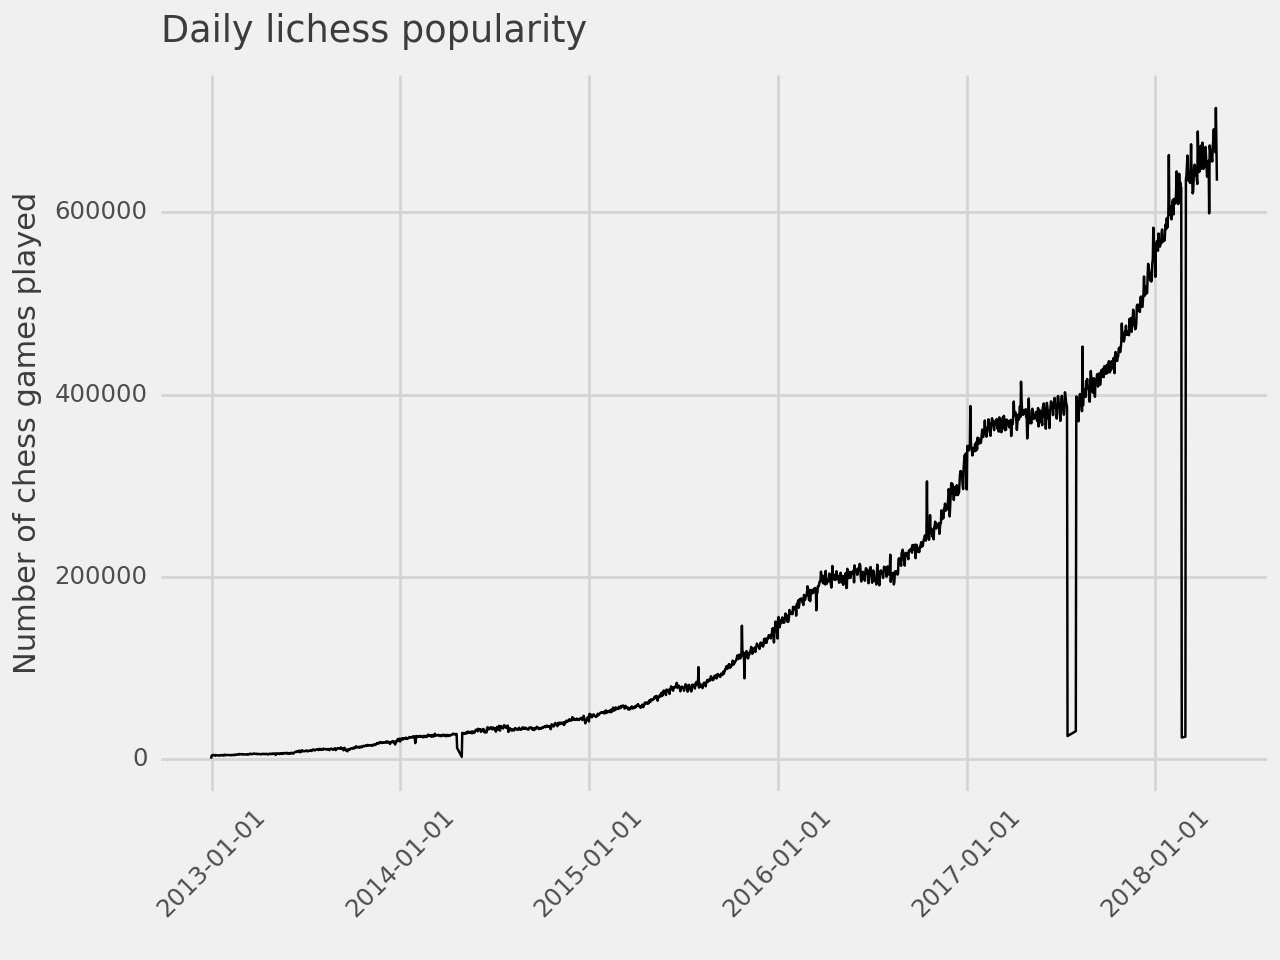

<Figure Size: (640 x 480)>

In [3]:
# How many games are played?
gamecount_df = (
    chess_df
    .group_by("UTCDate")
    .agg(pl.count())
    .sort("UTCDate")
    .collect()
)

plt = (
    p9.ggplot(gamecount_df, p9.aes(x="UTCDate", y="count"))
    + p9.geom_line()
    + p9.theme_538()
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
    + p9.labs(x="", y="Number of chess games played", title="Daily lichess popularity")
)

plt.save("img/gamecount_plot.png", width=10, height=6)
plt

C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: img/highcount_plot.png


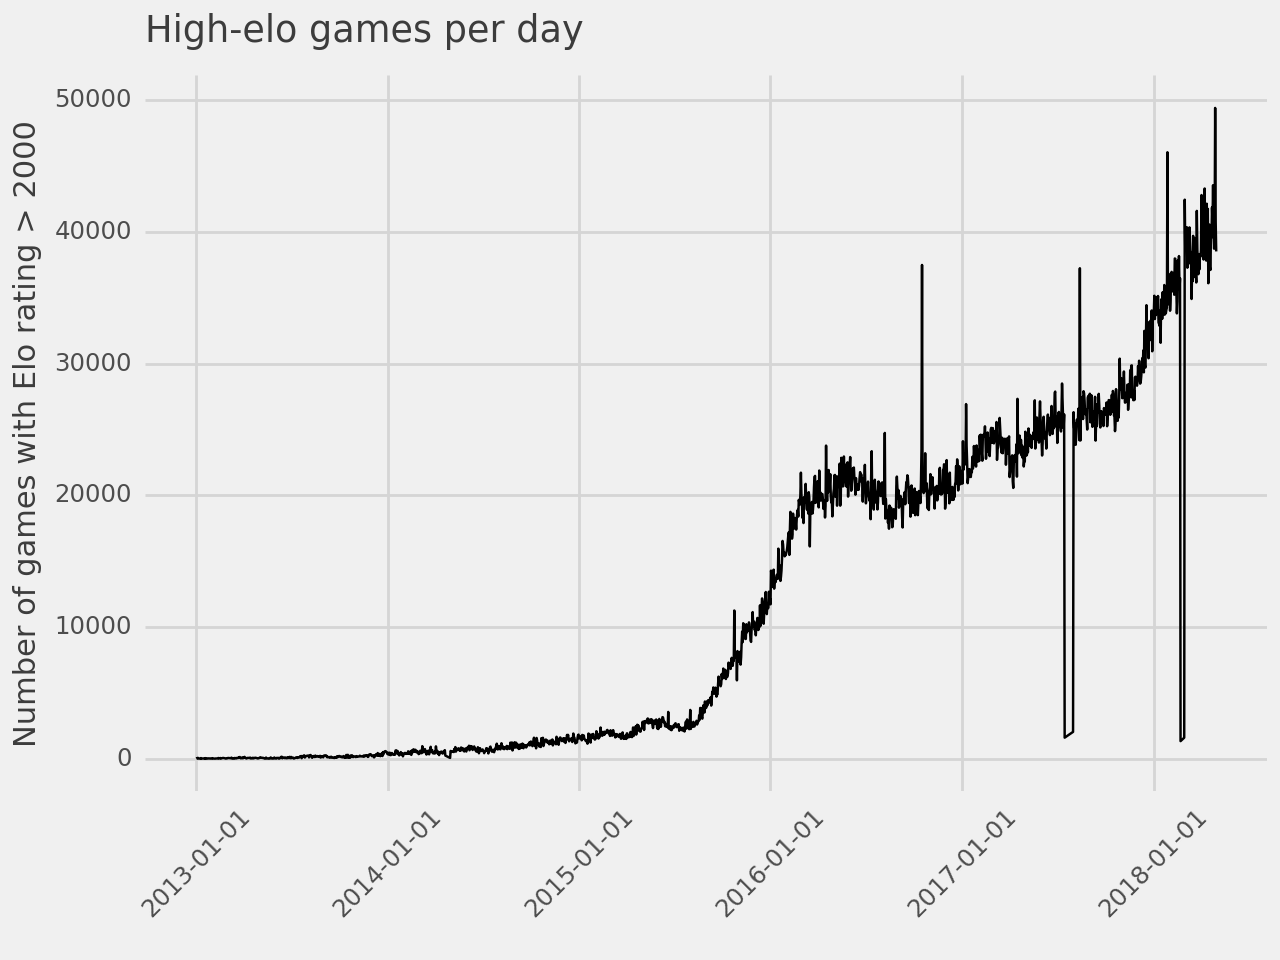

<Figure Size: (640 x 480)>

In [6]:
# now again but for high-elo rated players
highcount_df = (
    chess_df
    .filter(pl.col("WhiteElo") > 2000, pl.col("BlackElo") > 2000)
    .group_by("UTCDate")
    .agg(pl.count())
    .sort("UTCDate")
    .collect()
)

plt = (
    p9.ggplot(highcount_df, p9.aes(x="UTCDate", y="count"))
    + p9.geom_line()
    + p9.theme_538()
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
    + p9.labs(x="", y="Number of games with Elo rating > 2000", 
              title="High-elo games per day")
)

plt.save("img/highcount_plot.png", width=10, height=6)
plt

C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
C:\Users\erikj\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: img/opening_plot.png


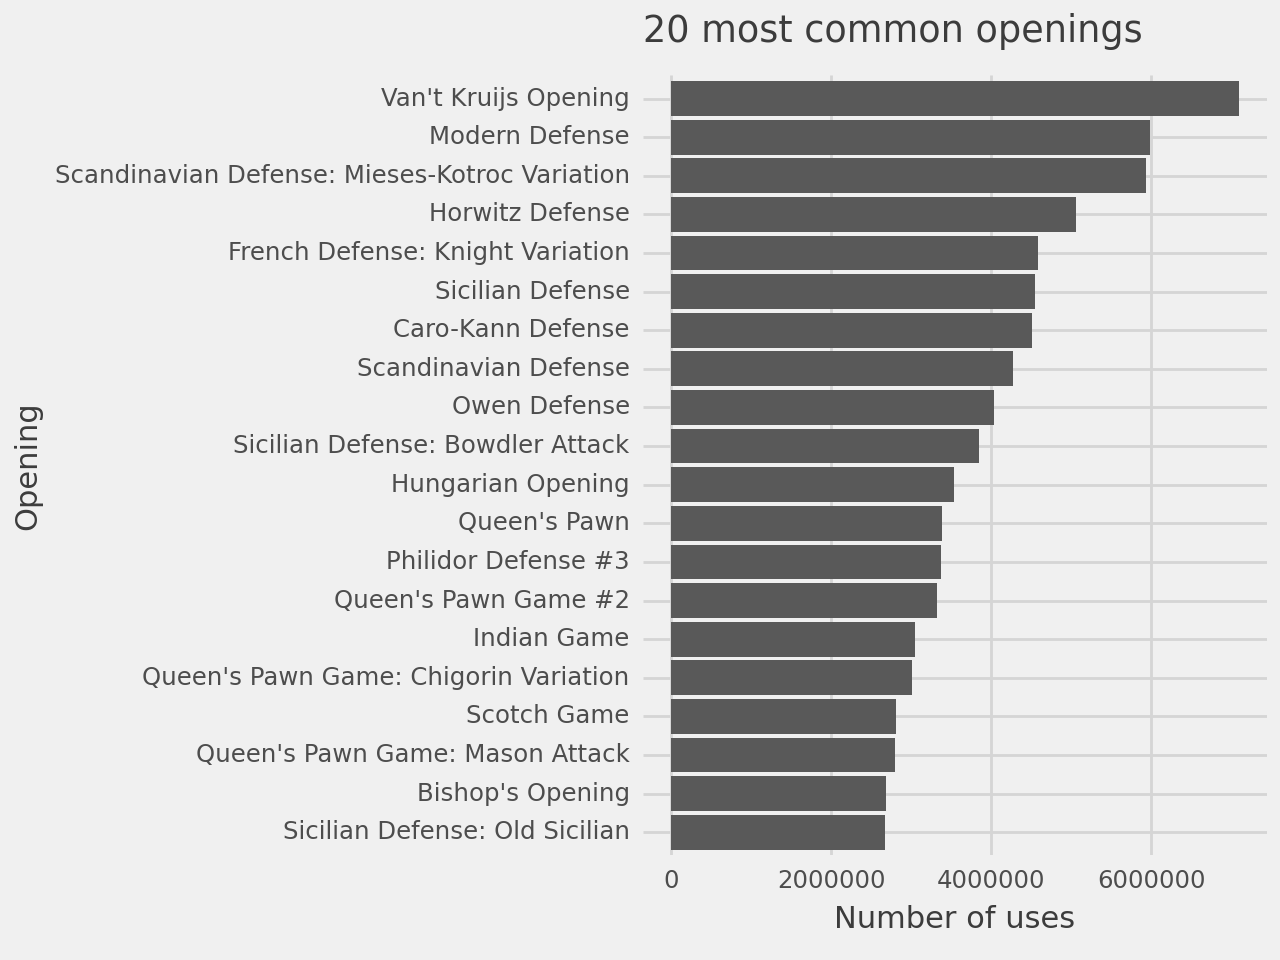

<Figure Size: (640 x 480)>

In [3]:
# let's look at the different openings
opening_df = (
    chess_df
    .group_by("Opening")
    .agg(pl.count())
    .sort("count")
    .tail(20)
    .with_columns(pl.col("Opening").cast(pl.Categorical))
    .collect(streaming=True)
)

plt = (
    p9.ggplot(opening_df, p9.aes(x="Opening", y="count"))
    + p9.geom_col()
    + p9.theme(axis_text_x=p9.element_text(rotation=90))
    + p9.coord_flip()
    + p9.theme_538()
    + p9.labs(x="Opening", y="Number of uses", title="20 most common openings")
)

plt.save("img/opening_plot.png", width=10, height=6)
plt
